<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_04%5DTry_changing_the_Vocabulary_Size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_04]Try changing the Vocabulary Size

지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼습니다. 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일에 한정되지 않을 수 있습니다. 데이터의 전처리는 모델의 성능에 영향을 직접적으로 줍니다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있겠죠.

중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.

> 따라서 단어의 수에 따라 모델의 성능이 어떻게 변하는지 테스트 해보겠습니다. 앞서 num_words로 사용할 단어의 수를 조정할 수 있다는 것을 배웠습니다. 빈도수가 많은 순서대로 나열했을 때, num_words의 인자로 준 정숫값만큼의 단어를 사용하고 나머지 단어는 전부 <unk>로 처리하는 원리였었죠.

## 1. Import 및 데이터 로드

In [7]:
# 기본 import 
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 벡터화
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# sklearn Mldel import
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# 평가
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 딥러닝
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow import keras
import tensorflow as tf

## 2. 함수구현

### 1) data_load
- 데이터 불러오기
- 데이터 분석
- 데이터 텍스트로 변환
- 데이터 벡터화

In [ ]:
def data_load(num_words, test_split=0.2):

  (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=test_split)

  if num_words == None:
    print('-'*25,'샘플수','-'*25)
    print('훈련 샘플의 수 : {}'.format(len(x_train)))
    print('테스트 샘플의 수 : {}'.format(len(x_test)))

    print()
    print('-'*25,'클래스의 수','-'*25)
    num_classes = max(y_train) + 1
    print('클래스의 수 : {}'.format(num_classes))

    print()
    print('-'*25,'길이','-'*25)
    print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
    print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

    print()
    print('-'*25,'데이터 분포','-'*25)
    plt.hist([len(s) for s in x_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

    print()
    print('-'*25,'클래스 분포','-'*25)
    fig, axe = plt.subplots(ncols=1)
    fig.set_size_inches(11,5)
    sns.countplot(x=y_train)
    plt.show()

  ## 데이터 텍스트로 처리
  word_index = reuters.get_word_index(path='reuters_word_index.json')
  index_to_word = {index+3 : word for word, index in word_index.items()}
  for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
    index_to_word[index]=token

  decoded = []
  for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

  x_train = decoded

  decoded = []
  for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

  x_test = decoded

  # 데이터 벡터화
  dtmvector = CountVectorizer()
  tfidf_transformer = TfidfTransformer()

  x_train_dtm = dtmvector.fit_transform(x_train)
  tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)

  x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
  tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

  return tfidfv_train, y_train, tfidfv_test, y_test


### 2) ML_Models

In [ ]:
def ML_Models(tfidfv, y_train, tfidfv_test, y_test):
  # 다항분포 나이브 베이즈
  mnb = MultinomialNB()
  mnb.fit(tfidfv, y_train)
  predicted = mnb.predict(tfidfv_test) #테스트 데이터에 대한 예측
  mnb_accuracy = accuracy_score(y_test, predicted)
  print("다항분포 나이브 베이즈 정확도:", mnb_accuracy) #예측값과 실제값 비교

  # Complement Naive Bayes Classifier(CNB)
  cb = ComplementNB()
  cb.fit(tfidfv, y_train)
  predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
  cv_accuracy = accuracy_score(y_test, predicted)
  print("컴플리먼트 나이브 베이즈 정확도:", cv_accuracy) #예측값과 실제값 비교

  # 로지스틱 회귀 분석
  lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
  lr.fit(tfidfv, y_train)
  predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
  lr_accuracy = accuracy_score(y_test, predicted)
  print("로지스틱 회귀 정확도:", lr_accuracy) #예측값과 실제값 비교

  # 선형 서포트 벡터 머신
  lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
  lsvc.fit(tfidfv, y_train)
  predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
  lsvc_accuracy = accuracy_score(y_test, predicted)
  print("선형 서포트 벡터 머신 정확도:", lsvc_accuracy) #예측값과 실제값 비교

  # 결정 트리
  tree = DecisionTreeClassifier(max_depth=10, random_state=0)
  tree.fit(tfidfv, y_train)
  predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
  tree_accuracy = accuracy_score(y_test, predicted)
  print("결정 트리 정확도:", tree_accuracy) #예측값과 실제값 비교

  # 랜덤 포레스트
  forest = RandomForestClassifier(n_estimators=5, random_state=0)
  forest.fit(tfidfv, y_train)
  predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
  forest_accuracy = accuracy_score(y_test, predicted)
  print("랜덤 포레스트 정확도:", forest_accuracy) #예측값과 실제값 비교

  # 그레디언 부스트
  grbt = GradientBoostingClassifier(random_state=0) # verbose=3
  grbt.fit(tfidfv, y_train)
  predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
  grbt_accuracy = accuracy_score(y_test, predicted)
  print("그레디언 부스트 정확도:", grbt_accuracy) #예측값과 실제값 비교

  # 보팅
  voting_classifier = VotingClassifier(estimators=[
          ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
          ('cb', ComplementNB()),
          ('grbt', GradientBoostingClassifier(random_state=0))
  ], voting='soft')
  voting_classifier.fit(tfidfv, y_train)
  predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
  voting_accuracy = accuracy_score(y_test, predicted)
  print("보팅 정확도:", voting_accuracy) #예측값과 실제값 비교

  return mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier, mnb_accuracy, cv_accuracy, lr_accuracy, lsvc_accuracy, tree_accuracy, forest_accuracy, grbt_accuracy, voting_accuracy


### 3) F1-Score, Confusion Matrix


In [ ]:

def fcm(models, tfidfv_test, y_test):
  for model in models:
    if model == mnb:
      model_name = 'Multinomial Naive Bayes Classifier'
    elif model == cb:
      model_name = 'Complement Naive Bayes Classifier'
    elif model == lr:
      model_name = 'Logistic Regression'
    elif model == lsvc:
      model_name = 'Linear Support Vector Machine'
    elif model == tree:
      model_name = 'Decision Tree'
    elif model == forest:
      model_name = 'Random Forest'
    elif model == grbt:
      model_name = 'GradientBoostingClassifier'
    else:
      model_name = 'Voting'
    
    print('-'*25,model_name,'-'*25)
    print()
    print("f1-score : ", classification_report(y_test, model.predict(tfidfv_test), zero_division=0))


    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(tfidfv_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('{} label'.format(model_name))
    plt.xlabel('{} predicted value'.format(model_name))



## 2. 모든 단어 사용

### 1) 데이터 로드

------------------------- 샘플수 -------------------------
훈련 샘플의 수 : 8982
테스트 샘플의 수 : 2246

------------------------- 클래스의 수 -------------------------
클래스의 수 : 46

------------------------- 길이 -------------------------
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633

------------------------- 데이터 분포 -------------------------


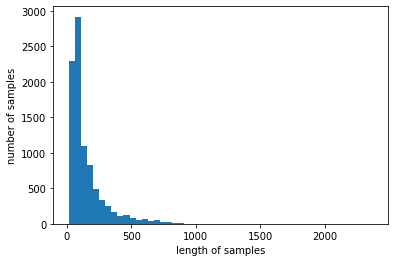


------------------------- 클래스 분포 -------------------------


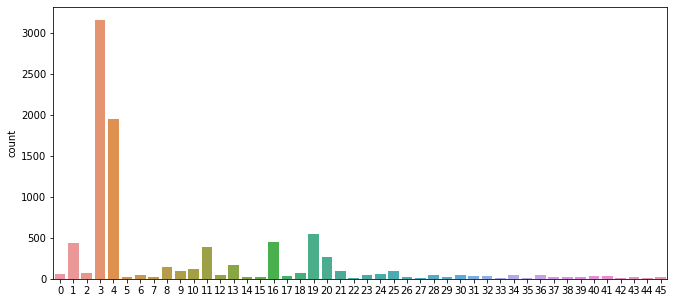

In [ ]:
tfidfv_train, y_train, tfidfv_test, y_test = data_load(num_words=None, test_split=0.2)

### 2) 모델 학습

In [ ]:
mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier, \
 all_mnb_accuracy, all_cv_accuracy, all_lr_accuracy, all_lsvc_accuracy, all_tree_accuracy, all_forest_accuracy, all_grbt_accuracy, all_voting_accuracy \
  = ML_Models(tfidfv_train, y_train, tfidfv_test, y_test)

다항분포 나이브 베이즈 정확도: 0.5997328584149599
컴플리먼트 나이브 베이즈 정확도: 0.7649154051647373
로지스틱 회귀 정확도: 0.8170080142475512


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


선형 서포트 벡터 머신 정확도: 0.790293855743544
결정 트리 정확도: 0.6211041852181657
랜덤 포레스트 정확도: 0.6544968833481746
그레디언 부스트 정확도: 0.7702582368655387
보팅 정확도: 0.8156723063223509


### 3) f1-score, Confusion Matrix

------------------------- Multinomial Naive Bayes Classifier -------------------------

f1-score :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00  

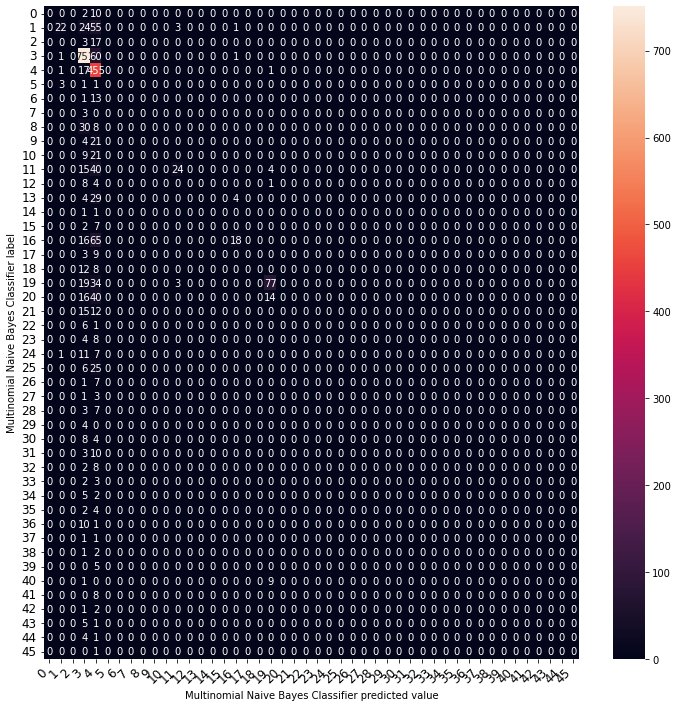

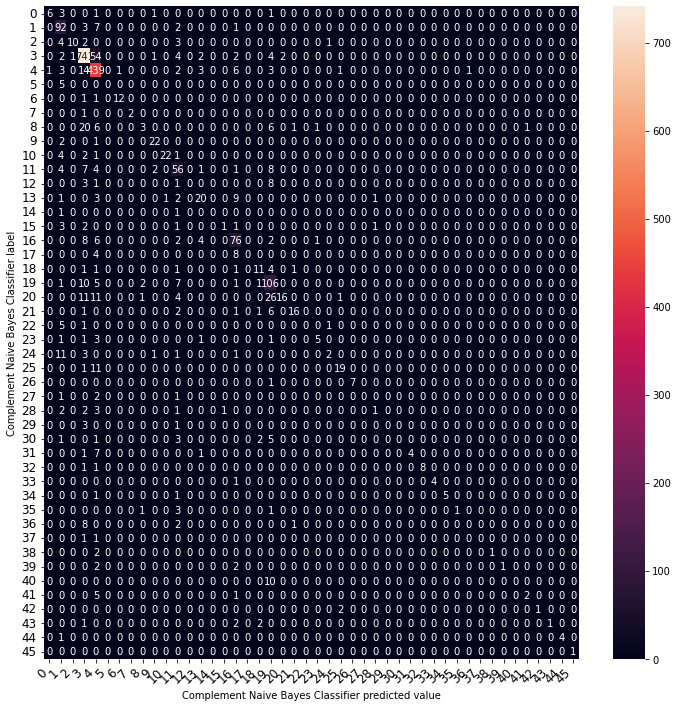

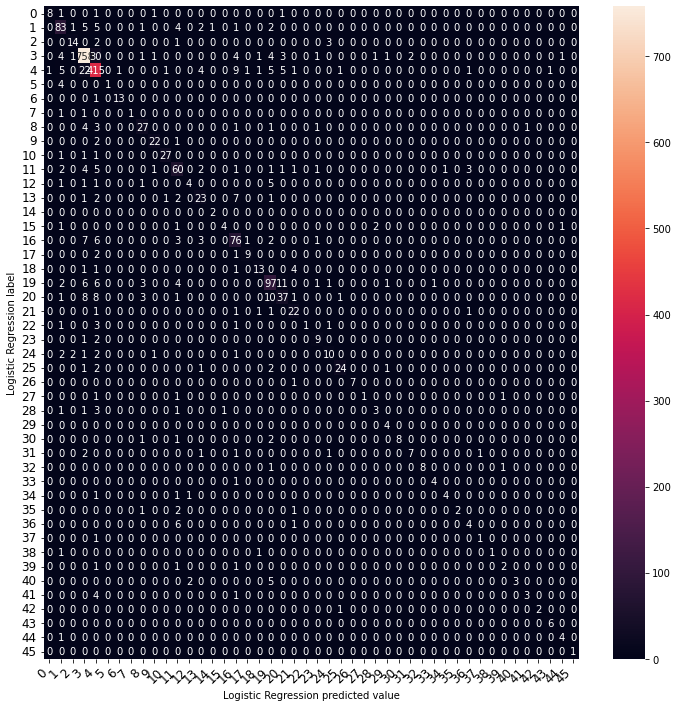

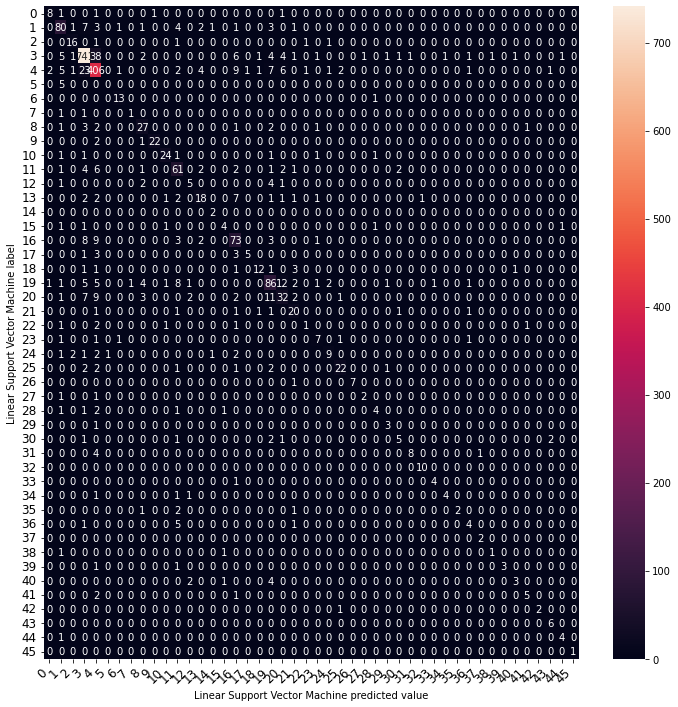

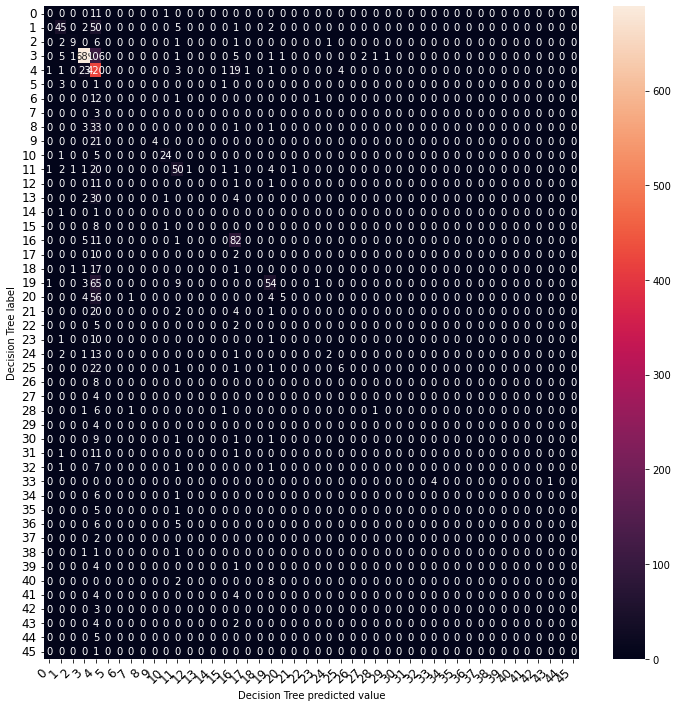

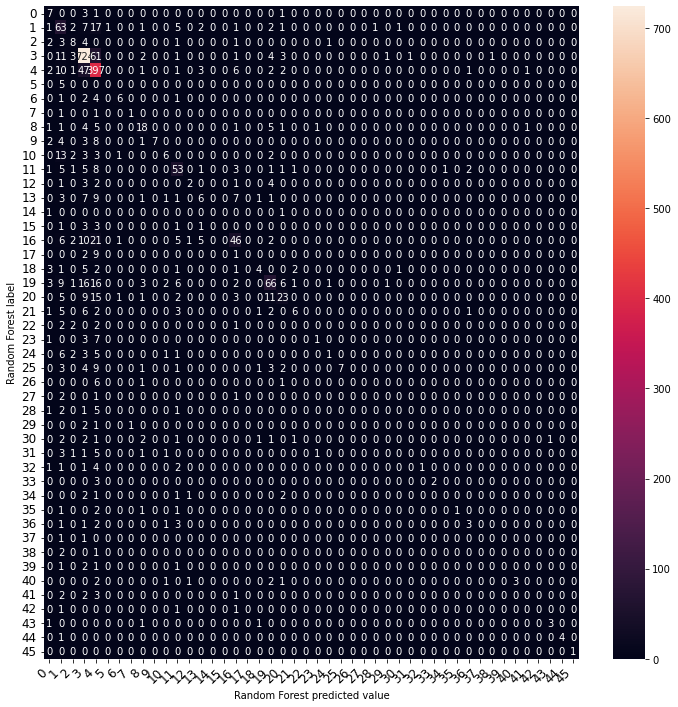

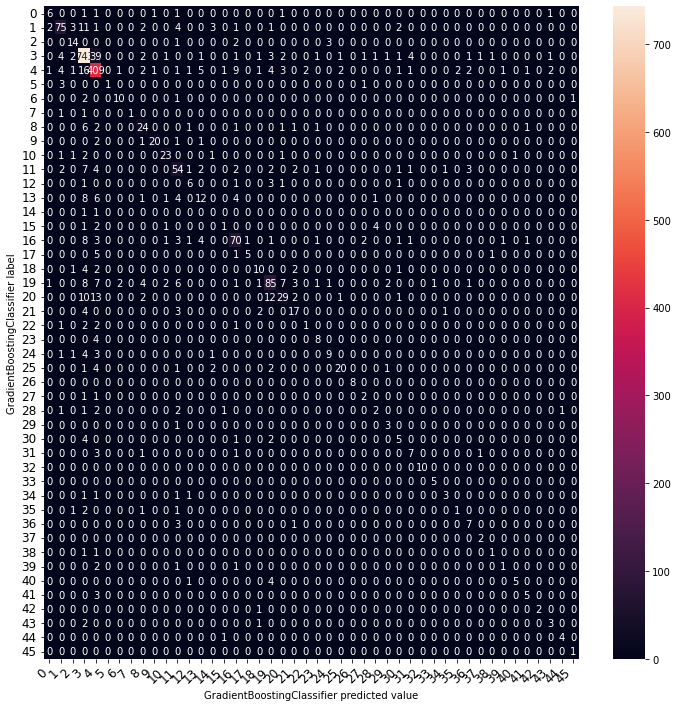

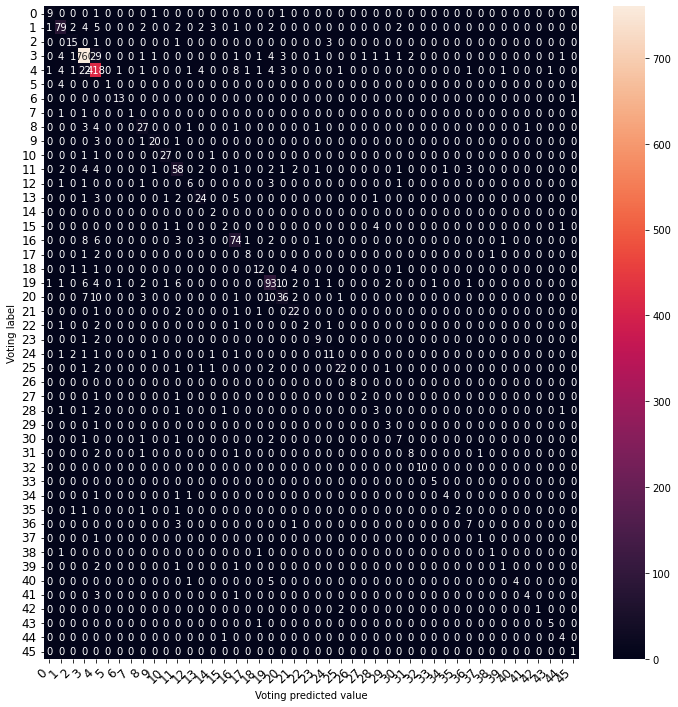

In [ ]:
models = [mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier]
fcm(models, tfidfv_test, y_test)

## 3. 빈도수 상위 5000개의 단어만 사용

In [ ]:
tfidfv_train, y_train, tfidfv_test, y_test = data_load(num_words=5000, test_split=0.2)

In [ ]:
mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier, \
ft_mnb_accuracy, ft_cv_accuracy, ft_lr_accuracy, ft_lsvc_accuracy, ft_tree_accuracy, ft_forest_accuracy, ft_grbt_accuracy, ft_voting_accuracy \
= ML_Models(tfidfv_train, y_train, tfidfv_test, y_test)

다항분포 나이브 베이즈 정확도: 0.6731967943009796
컴플리먼트 나이브 베이즈 정확도: 0.7707034728406055
로지스틱 회귀 정확도: 0.8032056990204809


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


선형 서포트 벡터 머신 정확도: 0.7769367764915405
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.701246660730187
그레디언 부스트 정확도: 0.767586821015138
보팅 정확도: 0.8098842386464826


------------------------- Multinomial Naive Bayes Classifier -------------------------

f1-score :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00  

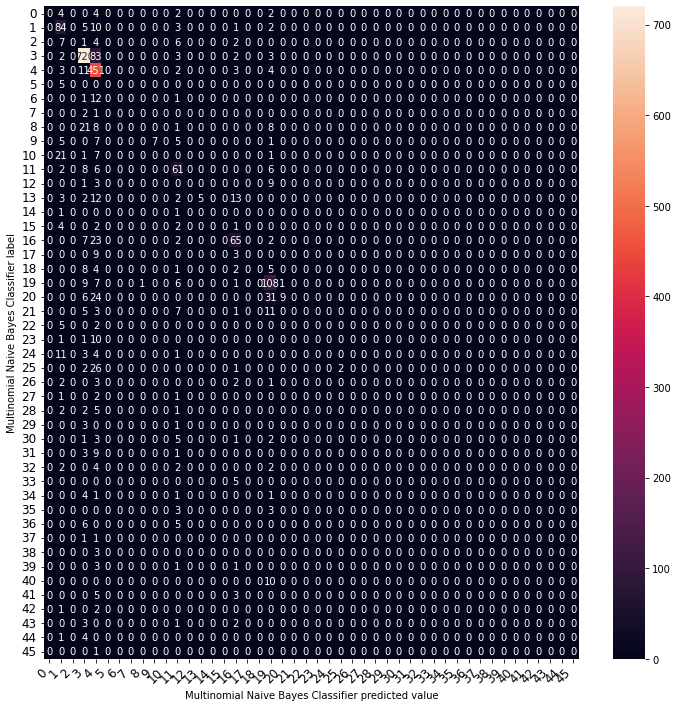

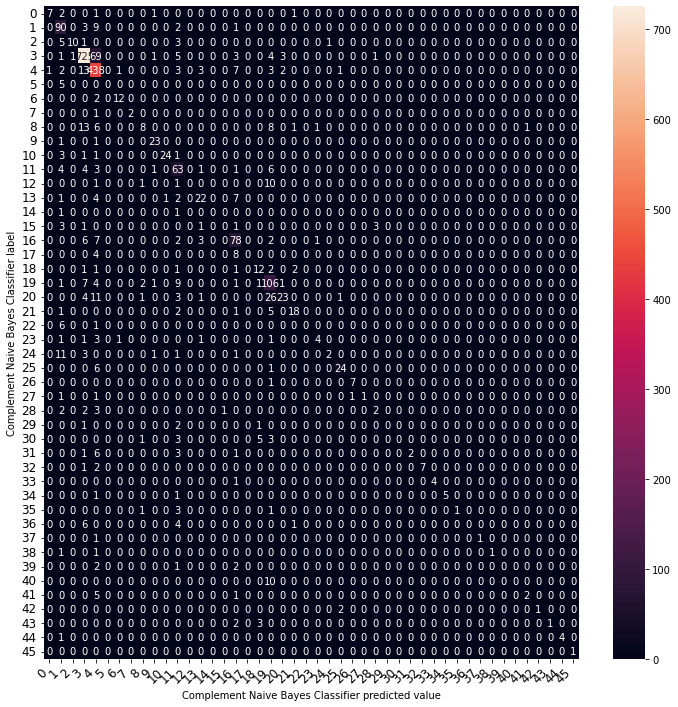

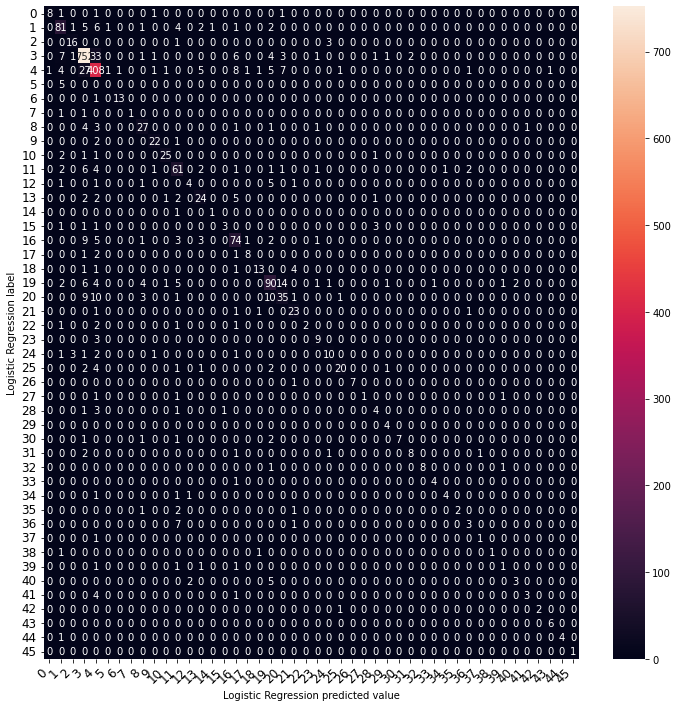

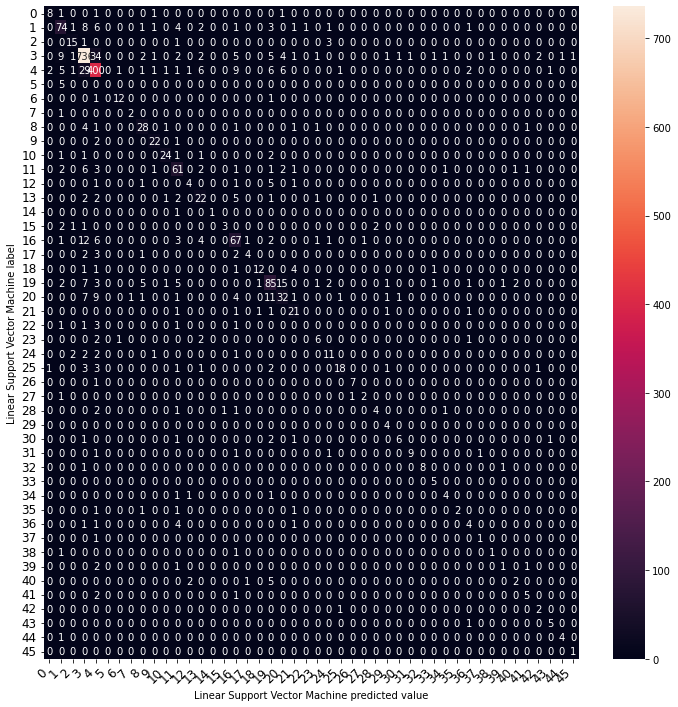

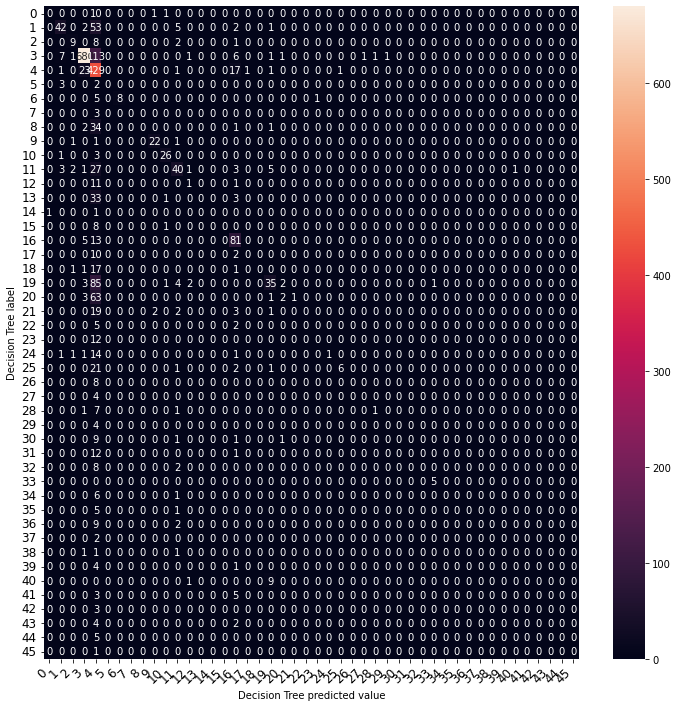

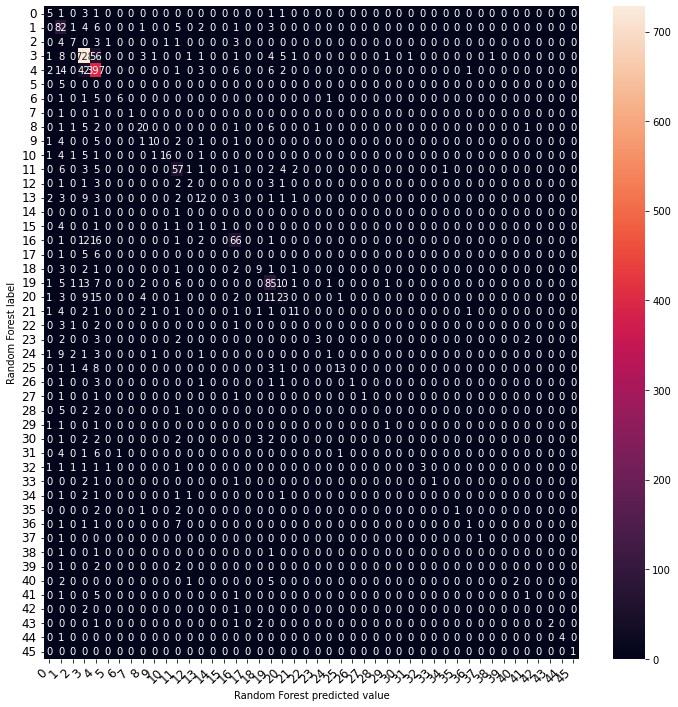

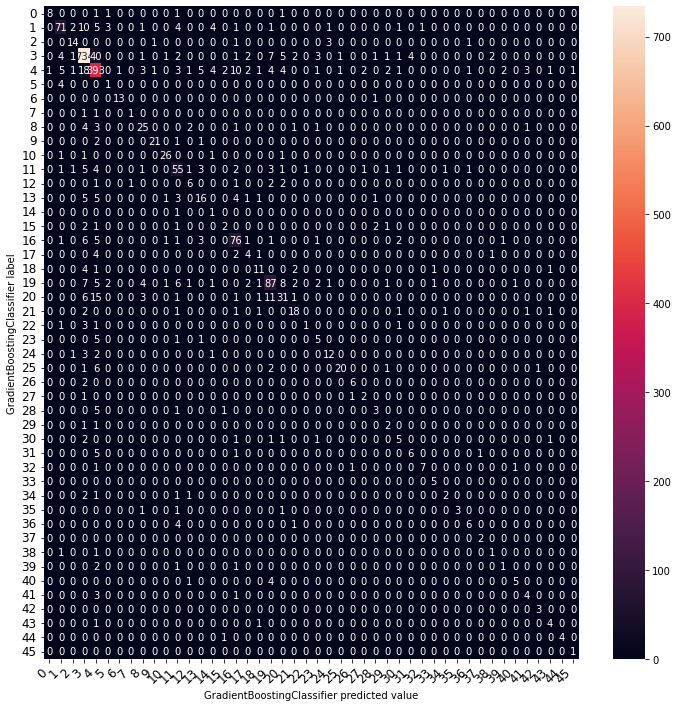

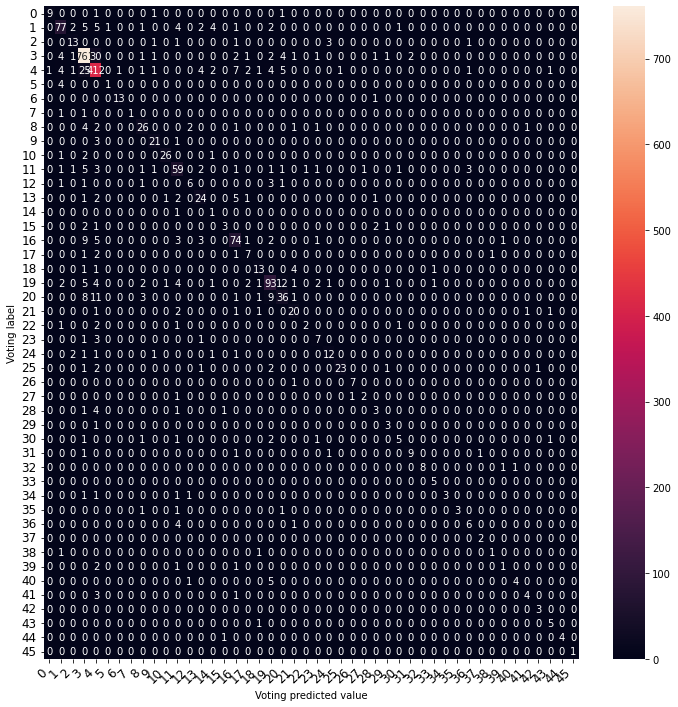

In [ ]:
models = [mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier]
fcm(models, tfidfv_test, y_test)

## 4. 직접 단어 개수를 설정해서 사용

In [ ]:
tfidfv_train, y_train, tfidfv_test, y_test = data_load(num_words=1000, test_split=0.2)

In [ ]:
mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier, \
t_mnb_accuracy, t_cv_accuracy, t_lr_accuracy, t_lsvc_accuracy, t_tree_accuracy, t_forest_accuracy, t_grbt_accuracy, t_voting_accuracy \
= ML_Models(tfidfv_train, y_train, tfidfv_test, y_test)

다항분포 나이브 베이즈 정확도: 0.6856634016028496
컴플리먼트 나이브 베이즈 정확도: 0.7346393588601959
로지스틱 회귀 정확도: 0.738646482635797


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


선형 서포트 벡터 머신 정확도: 0.719946571682992
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.707479964381122
그레디언 부스트 정확도: 0.7457702582368655
보팅 정확도: 0.7649154051647373


------------------------- Multinomial Naive Bayes Classifier -------------------------

f1-score :                precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.46      0.76      0.58       105
           2       0.00      0.00      0.00        20
           3       0.92      0.86      0.89       813
           4       0.60      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.78      0.37      0.50        38
           9       0.91      0.40      0.56        25
          10       1.00      0.20      0.33        30
          11       0.44      0.81      0.57        83
          12       0.00      0.00      0.00        13
          13       1.00      0.11      0.20        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00  

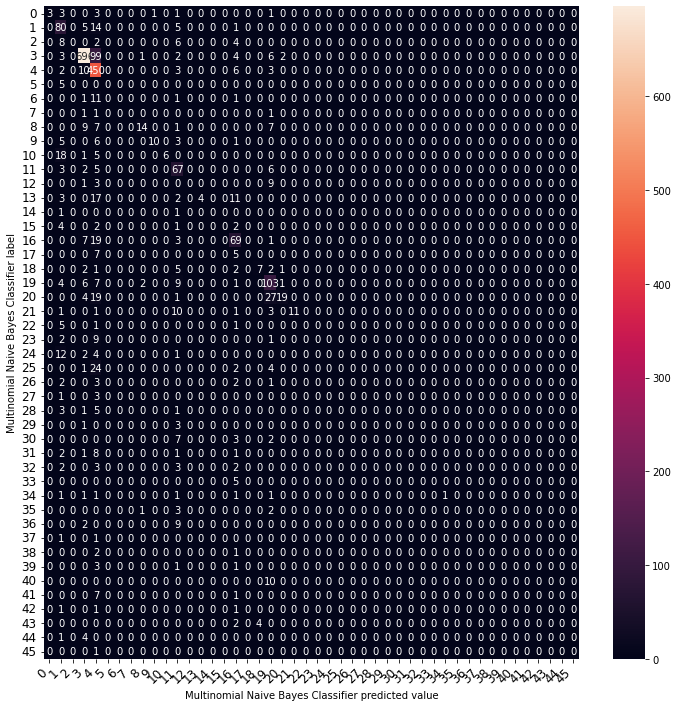

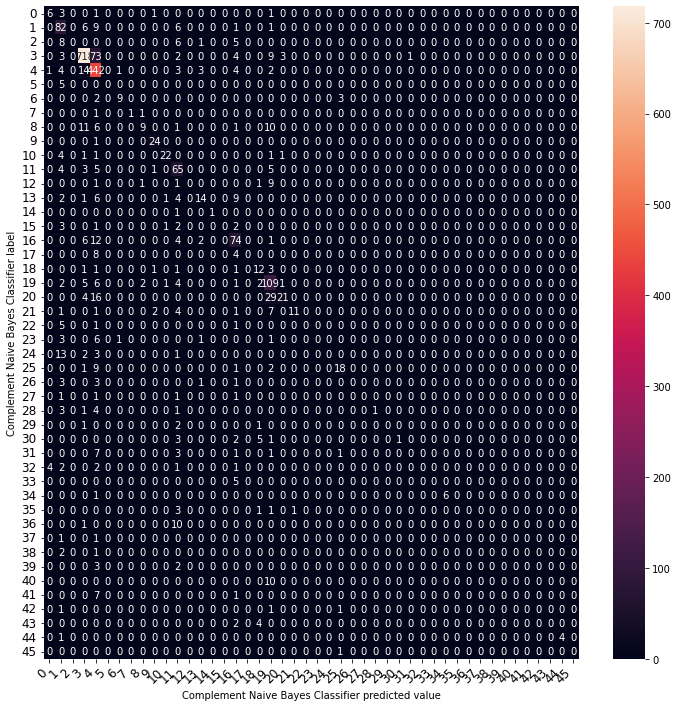

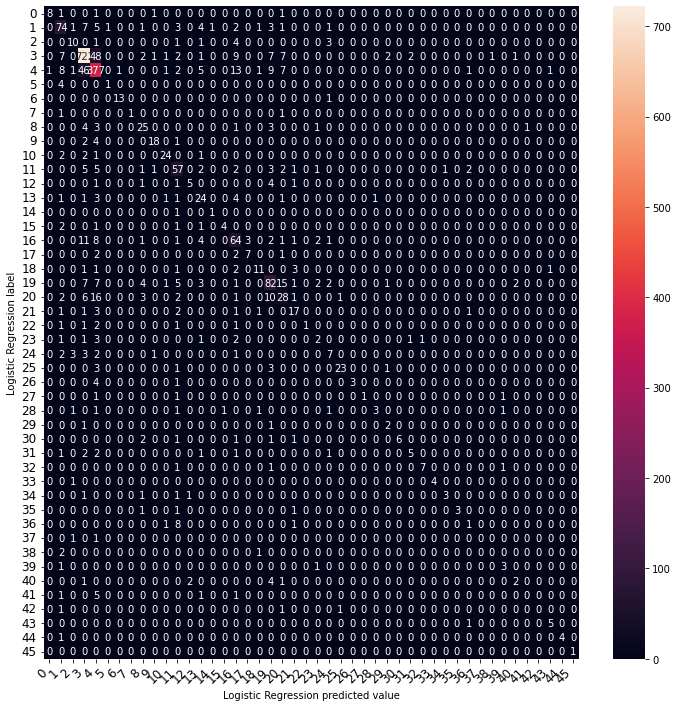

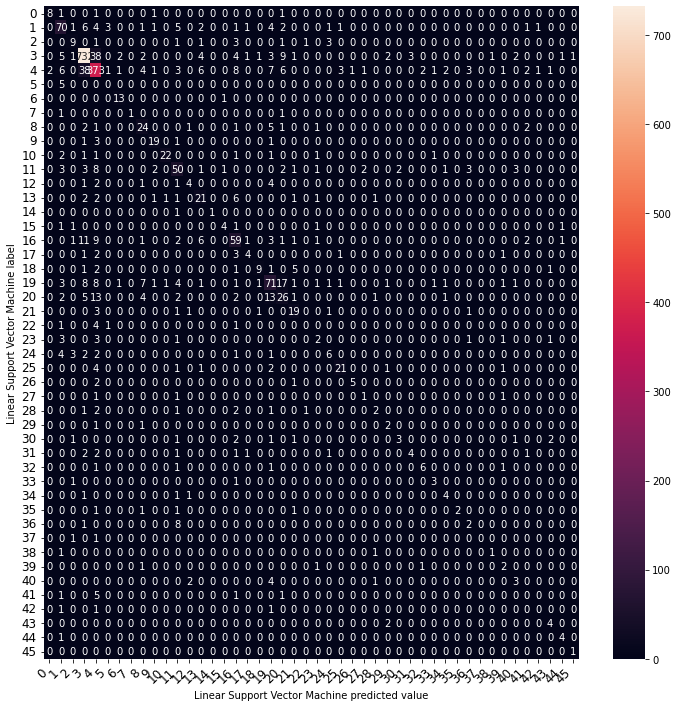

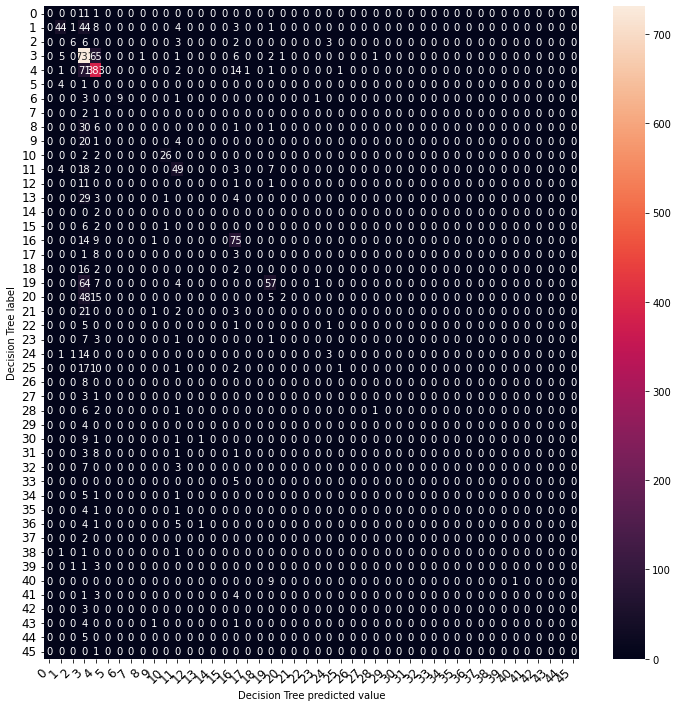

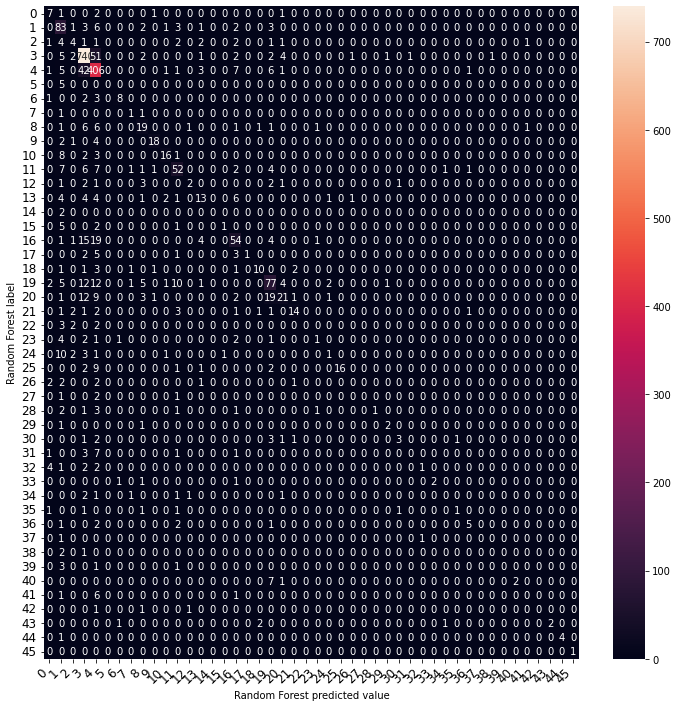

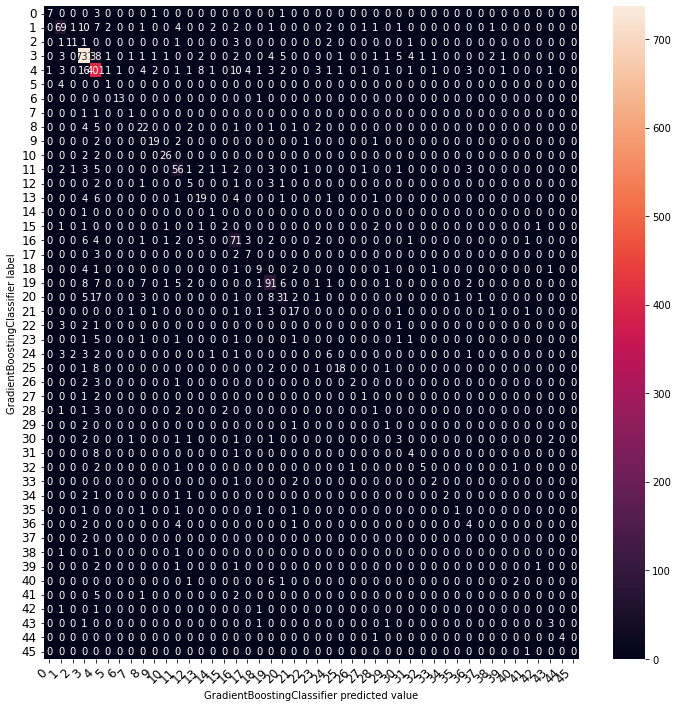

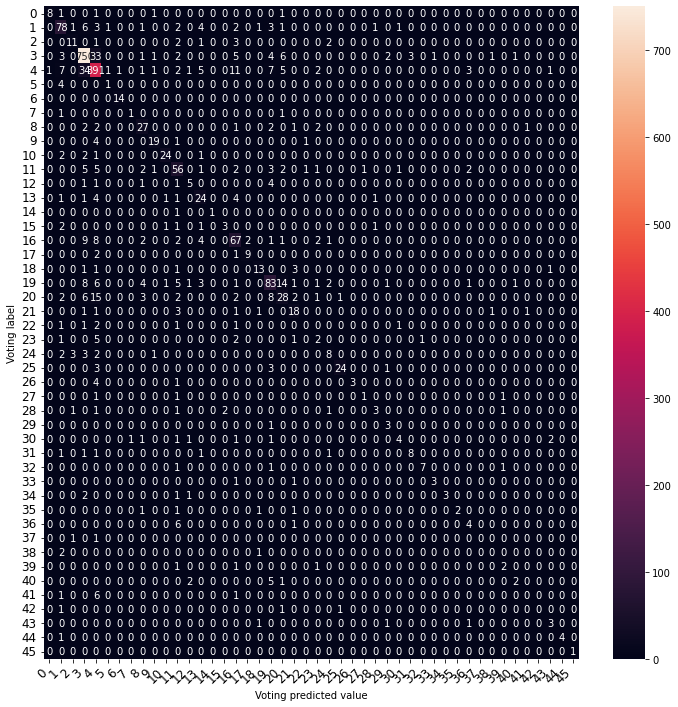

In [ ]:
models = [mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier]
fcm(models, tfidfv_test, y_test)

## 5. Vocabulary Size별 8가지 모델 비교
- 전제 모델별 accuracy의 추이를 파악한다.
- 그리고 딥러닝과 비교하기 위한 모델을 선택하기 위해서 정확도를 통해서 자세하게 살펴볼 모델의 갯수를 줄인다.
- 그후 f1-score의 weighted로 각 클래스에 속하는 표본의 개수로 가중을 매겨 보다 정밀한 f1를 가지고 비교하여 최종 모델을 선택한다.

> 참고자료
- f1-score :  https://sumniya.tistory.com/26
- macro vs weighted1 : https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f
- macro vs weighted2 : https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

### 1) 전체 모델별 accuracy 추이

In [ ]:
pd.DataFrame({'모델이름' : ['Multinomial Naive Bayes Classifier', 'Complement Naive Bayes Classifier', 'Logistic Regression', 'Linear Support Vector Machine', 'Decision Tree', 'Random Forest', 'GradientBoostingClassifier','Voting'],\
             '모든 단어' : [all_mnb_accuracy, all_cv_accuracy, all_lr_accuracy, all_lsvc_accuracy, all_tree_accuracy, all_forest_accuracy, all_grbt_accuracy, all_voting_accuracy],\
             '5000 단어' : [ft_mnb_accuracy, ft_cv_accuracy, ft_lr_accuracy, ft_lsvc_accuracy, ft_tree_accuracy, ft_forest_accuracy, ft_grbt_accuracy, ft_voting_accuracy],\
             '1000 단어' : [t_mnb_accuracy, t_cv_accuracy, t_lr_accuracy, t_lsvc_accuracy, t_tree_accuracy, t_forest_accuracy, t_grbt_accuracy, t_voting_accuracy]})

,모델이름,모든 단어,5000 단어,1000 단어
0,Multinomial Naive Bayes Classifier,0.599733,0.673197,0.685663
1,Complement Naive Bayes Classifier,0.764915,0.770703,0.734639
2,Logistic Regression,0.817008,0.803206,0.738646
3,Linear Support Vector Machine,0.790294,0.776937,0.719947
4,Decision Tree,0.621104,0.617988,0.617988
5,Random Forest,0.654497,0.701247,0.707480
6,GradientBoostingClassifier,0.770258,0.767587,0.745770
7,Voting,0.815672,0.809884,0.764915


> 나이브 베이즈 분류를 제외하고는 다른 모델은 Vocabulary Size가 클수록 더 높은 정확도를 보여주고 있다. 반대로 나이브 베이즈계열의 모델은 Vocabulary Size가 1000이거나 5000일때 더 높은 정확도를 보여주고 있다.

- 나이브 베이즈는 조건후 확률을 계산하는 방법 중 하나이기 때문에 겹치는 단어가 많을수록 확률이 올라간다. 
- 즉 Vocabulary Size를 줄여 단어의 다양성을 줄였기 때문에 다른 모델들과 달리 모든단어가 아닌 5000혹은 1000을 사용할때 가장 높은 정확도를 보여주고 있다.
- 그렇다고 무조건 Vocabulary Size가 작다고 정확도가 높은 것은 아니니 주의해야 한다.

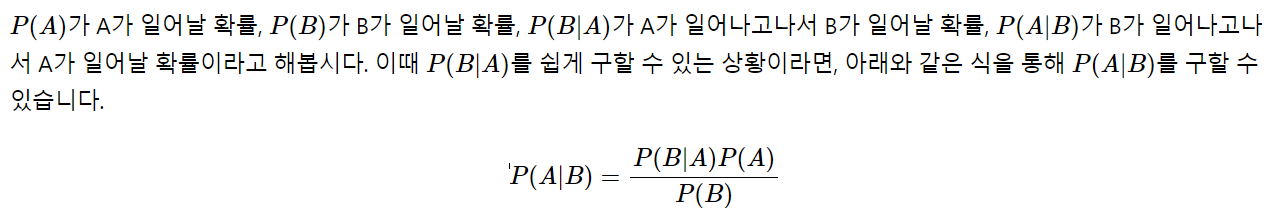
- 출처 : https://wikidocs.net/22892

## 2) 딥러닝과 비교를 위한 모델 선택(accuracy로 선택폭 줄이기)

> Vocabulary Size를 고려하여 가장 높은 accuracy를 보여주는 모델은 Logistic Regression과 Voting이다. 다음 스텝에서는 f1-score를 비교하여 최종 결정을 진행하겠다.

### 3) 최종 모델 선택(weighted 사용)
- Logistic Regression
  - 모든 단어 : 0.81
  - 5000 : 0.80
  - 1000 : 0.73
- Voting 
  - 모든 단어 : 0.81
  - 5000 : 0.81
  - 1000 : 0.76

> 미세하기는 하지만 Viting가 Vocabulary Size에 따른 불균형 문제를 더 잘 해결해 주고 있다. 우리가 사용한 Voting은 정확하게 소프트 보팅이다. 보팅이 불균형 문제를 더 잘 해결해준 이유는 소프트 보팅은 최종 결과물이 나올 확률값(여기서는 컴플리먼트 나이브 베이즈, 로지스틱 회귀, 그래디언 부스팅 트리 사용)을 다 더해서 최종 결과물에 대한 각각의 확률을 구한 뒤 최종값을 도출해내기 때문이다. <br><br> 최종 선택은 Voting이다.

## 6. 딥러닝 모델과 비교하기

### 1) RNN 학습(vocab_size=1000 기준)

In [8]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

word_index = reuters.get_word_index(path='reuters_word_index.json')
index_to_word = {index+3 : word for word, index in word_index.items()}
for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
  index_to_word[index]=token


decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

In [9]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv_train.shape)

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) 
print(tfidfv_test.shape)

tfidfv_arr = tfidfv_train.toarray()
tfidfv_dense = tfidfv_train.todense()
tfidfv_test_arr = tfidfv_test.toarray()
tfidfv_test_dense = tfidfv_test.todense()

(8982, 969)
(8982, 969)
(2246, 969)


In [10]:
embedding_dim = 128
hidden_units = 128
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))
vocab_size = 1000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
            
epochs=20
batch_size=64


history = model.fit(tfidfv_arr,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[es],
                    validation_split=0.2,
                    verbose=1)

클래스의 수 : 46
Epoch 1/20
113/113 [==============================] - 11s 71ms/step - loss: 2.5258 - accuracy: 0.3474 - val_loss: 2.4273 - val_accuracy: 0.3450
Epoch 2/20
113/113 [==============================] - 8s 67ms/step - loss: 2.4172 - accuracy: 0.3534 - val_loss: 2.4069 - val_accuracy: 0.3450
Epoch 3/20
113/113 [==============================] - 8s 67ms/step - loss: 2.4147 - accuracy: 0.3534 - val_loss: 2.4181 - val_accuracy: 0.3450
Epoch 4/20
113/113 [==============================] - 8s 67ms/step - loss: 2.4171 - accuracy: 0.3534 - val_loss: 2.4172 - val_accuracy: 0.3450
Epoch 5/20
113/113 [==============================] - 8s 67ms/step - loss: 2.4139 - accuracy: 0.3534 - val_loss: 2.4114 - val_accuracy: 0.3450
Epoch 6/20
113/113 [==============================] - 8s 67ms/step - loss: 2.4106 - accuracy: 0.3534 - val_loss: 2.4132 - val_accuracy: 0.3450
Epoch 6: early stopping


In [11]:
results_dense = model.evaluate(tfidfv_test_dense,  y_test, verbose=2)
print(results_dense)

71/71 - 1s - loss: 2.4256 - accuracy: 0.3620 - 1s/epoch - 20ms/step
[2.4256198406219482, 0.36197686195373535]


### 2) Voting, RNN 비교

- Voting(1000기준)
  - 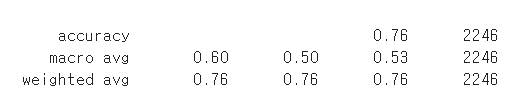
- RNN(1000 기준)
  - 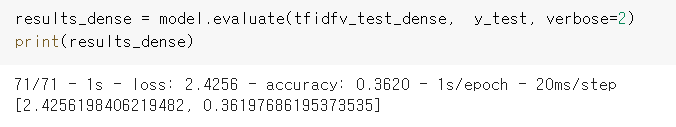

### 3) 결론

- Vting : 0.76
- RNN : 0.36

> 결론은 Voting가 훨씬 더 좋은 성능을 보이고 있다. 딥러닝의 알고리즘의 경우 터무니 없을 정도로 낮은 정확도를 보여주고 있다. 이유는 TF-IDF가 통계 기반 추론으로 머신러닝에 적합한 전처리 기법이다. RNN에는 잘 맞지 않는다. 딥러닝에는 추론 기반 알고리즘은 Word2ved등을 사용해야 한다.

## 7. 회고

## 루브릭 조건

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
  - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.

2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
  - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.

3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
  - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.